In [68]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("ggplot")
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tensorflow import keras
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import validation_curve,train_test_split,cross_validate
from sklearn.metrics import roc_curve,precision_recall_curve,confusion_matrix
import seaborn as sns
import numpy as np
import pickle

In [69]:
train=pd.read_csv("haha_2019_train.csv")

In [70]:
train.head()

,id,text,is_humor,votes_no,votes_1,votes_2,votes_3,votes_4,votes_5,funniness_average
0,705196579758583809,Niveles de retraso mental: \r\n\r\n— Bajo.\r\n...,1,1,2,2,0,0,0,1.5
1,678040651817213952,"—Vamos Luke desenfunda tu sable, demuestra tu ...",1,1,3,0,1,0,0,1.5
2,546750892213829633,"- ¿Te ofrezco algo?, ¿Agua, café, mi corazón, ...",1,0,2,1,0,1,1,2.6
3,965807211292364801,No se porqué me hago la cabeza deooos,0,3,0,0,0,0,0,NaN
4,638403841839484928,Quisiera saber que hago durante la siesta de l...,0,4,0,1,0,0,0,NaN


In [71]:
train.set_index("id",inplace=True)

In [72]:
train.fillna(0,inplace=True)

In [73]:
train.shape

(24000, 9)

In [74]:
X=train["text"]
y=train["is_humor"]

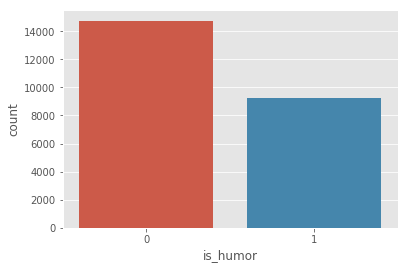

In [75]:
sns.countplot(x="is_humor", data=train)

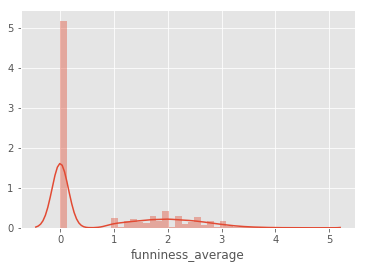

In [76]:
sns.distplot(train["funniness_average"])

In [84]:
def Countvector(X,y):
    global cv
    cv=CountVectorizer()
    return cv.fit_transform(X)

In [85]:
def Tfidf(X,y):
    global cv
    cv=TfidfVectorizer()
    return cv.fit_transform(X)

In [86]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [87]:
X_vect=Countvector(X,y)
sum_digits=[]
sum_char=[]
    
for j in X.str.findall(r"\W"):
    char_count=0
    for i in j:
        char_count+=1
    sum_char.append(char_count)
for j in X:
    spam_digit_count=0
    for i in j:
        if i.isdigit():
            spam_digit_count+=1
    sum_digits.append(spam_digit_count)
    
X_transformed=add_feature(X_vect,[[len(i) for i in X],sum_digits,sum_char])
    


In [88]:
X_vect=Tfidf(X,y)
sum_digits=[]
sum_char=[]
    
for j in X.str.findall(r"\W"):
    char_count=0
    for i in j:
        char_count+=1
    sum_char.append(char_count)
for j in X:
    spam_digit_count=0
    for i in j:
        if i.isdigit():
            spam_digit_count+=1
    sum_digits.append(spam_digit_count)
    
X_transformed=add_feature(X_vect,[[len(i) for i in X],sum_digits,sum_char])

In [15]:
def Machine_learning_testing_train_test_split(clf,X,y):
        Name=str(clf)
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33,random_state=42)
        clf.fit(X_train,y_train)
        ##saving the dataset
        
        with open('{}.pkl'.format(Name[:20]), 'wb') as fid:
            pickle.dump(clf, fid)  
        
        y_train_scores=clf.predict_proba(X_train)[:,1]
        y_test_scores=clf.predict_proba(X_test)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_scores)
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_scores)
        ##roc curve
        fig1=plt.figure()
        ax1=fig1.add_subplot(111)
        ax1.plot(fpr_train,tpr_train)
        ax1.plot([0,1],[0,1],linestyle='dashed')
        ax1.set_title("ROC Curve--Train for {}".format(Name[:20]))
        ax1.set_xticks([],[])
        ax1.set_ylabel("True Positive Rate")
        
        fig2=plt.figure()
        ax2=fig2.add_subplot(111)
        ax2.plot([0,1],[0,1],linestyle='dashed')
        ax2.plot(fpr_train,tpr_train,color="green")
        ax2.set_title("ROC Curve--Test for {}".format(Name[:20]))
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        
        print("The score(Train)  for {} is:".format(Name[:20]),clf.score(X_train,y_train))
        print("The score(Test)  for {} is:".format(Name[:20]),clf.score(X_test,y_test))
        ###threshold graph with accuracy and precision:
        probs=clf.predict_proba(X)[:,1]
        df=pd.DataFrame()
        df["thresholds"]=probs
        df["actual_labels"]=y
        accuracy=[]
        threshold=np.arange(0.1,1,.1).tolist()
        for i in threshold:
            df["predicted_labels"]=np.where(df["thresholds"]>=i,1,0)
            df["Correct"]=df["actual_labels"]==df["predicted_labels"]
            correct=len(df[(df["Correct"]==True)])
            accuracy.append(correct/len(df))
        precisions, recalls, thresholds = precision_recall_curve(y, probs)
        
        fig3=plt.figure()
        ax3=fig3.add_subplot(111)
        ax3.plot(thresholds, precisions[:-1], 'b--', label='precision')
        ax3.plot(threshold, accuracy, 'g--', label = 'accuracy')
        ax3.set_xlabel('Threshold')
        ax3.legend(loc='upper left')
        ax3.set_ylim([0,1])
        
        
        ###confusion matrix
        y_pred=clf.predict(X)
        print("OverAll Confusion Matrix for {}".format(Name[:20]))
        print(confusion_matrix(y, y_pred))
        

In [16]:
def Cross_validation_curve_parameter(X,y,clf):
    Name=str(clf)
    param_name="alpha"
    param_range = np.logspace(-6, -1, 5)
    train_scores, test_scores = validation_curve(
    clf, X, y,cv=5, scoring="accuracy",param_name="alpha", param_range=param_range, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve for {} over different {} values".format(Name[:20],param_name))
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [17]:
def Cross_validation(X,y,clf):
    from statistics import mean,stdev
    import scipy.stats as stats
    cv_results  = cross_validate(clf, X, y,cv=5, scoring="accuracy", n_jobs=1)
    train_scores=cv_results["train_score"]
    print("The training score for {} with cv 5".format(str(clf)[:20]),train_scores)
    test_scores=cv_results["test_score"]
    print("The testing score for {} with cv 5".format(str(clf)[:20]),test_scores)
    train_scores_mean = mean(train_scores)
    train_scores_std = stdev(train_scores)
    fig1=plt.figure()
    fit = stats.norm.pdf(train_scores,train_scores_mean , train_scores_std)  #this is a fitting indeed
    plt.title("Accuracy distribution Training set")
    plt.plot(train_scores,fit,'-o')
    plt.hist(train_scores,normed=True)      #use this to draw histogram of your data
    plt.show()                   #use may also need add this 
    
    
    test_scores_mean = mean(test_scores)
    test_scores_std = stdev(test_scores)
    fig2=plt.figure()
    fit = stats.norm.pdf(test_scores,test_scores_mean , test_scores_std)  #this is a fitting indeed
    plt.title("Accuracy distribution Test set")
    plt.plot(test_scores,fit,'-o')
    plt.hist(test_scores,normed=True)      #use this to draw histogram of your data
    plt.show() 
    
    
    
    
    fig3=plt.figure()
    plt.title("Validation Curve")
    plt.xlabel("CV")
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1,.1)
    plt.plot([1,2,3,4,5],train_scores,color="green",label="training_score")
    plt.plot([1,2,3,4,5],test_scores,color="red",label="testing_score")
    plt.legend(loc="best")
    plt.show()

The score(Train)  for LogisticRegression(C is: 0.9482587064676616
The score(Test)  for LogisticRegression(C is: 0.8128787878787879
OverAll Confusion Matrix for LogisticRegression(C
[[14038   709]
 [ 1605  7648]]


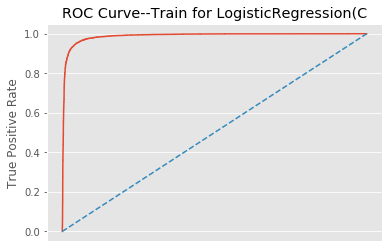

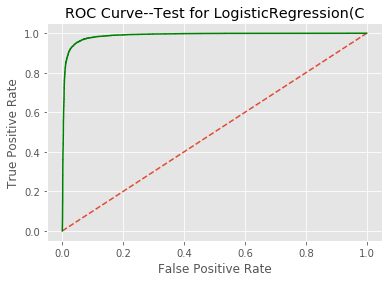

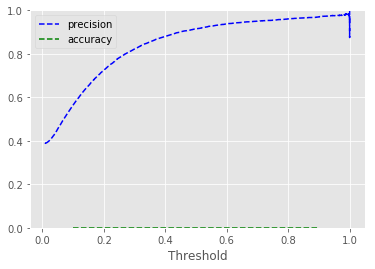

In [162]:
Machine_learning_testing_train_test_split(LogisticRegression(),X_transformed,y)

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


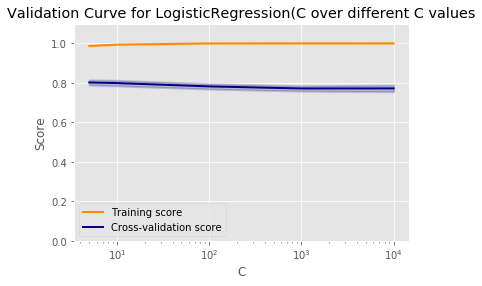

In [163]:
Cross_validation_curve_parameter(X_transformed,y,LogisticRegression())

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


The training score for LogisticRegression(C with cv 5 [0.9421324  0.94348664 0.94171875 0.94286756 0.94594032]
The testing score for LogisticRegression(C with cv 5 [0.81503853 0.82170381 0.81854167 0.81391957 0.79620754]


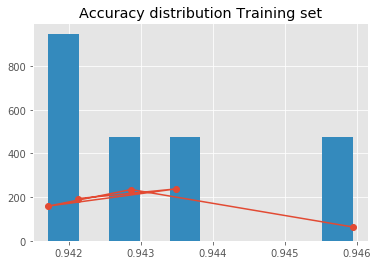

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


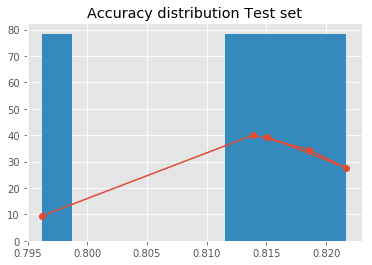

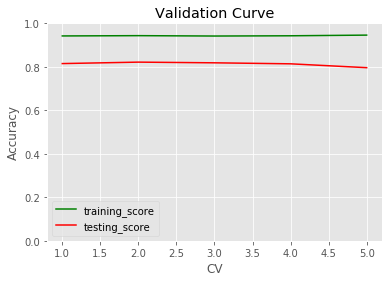

In [166]:
Cross_validation(X_transformed,y,LogisticRegression())

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The score(Train)  for SVC(C=1.0, cache_siz is: 0.7573383084577114
The score(Test)  for SVC(C=1.0, cache_siz is: 0.7563131313131313
OverAll Confusion Matrix for SVC(C=1.0, cache_siz
[[13294  1453]
 [ 4379  4874]]


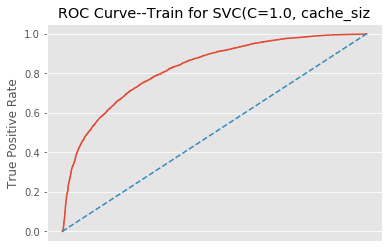

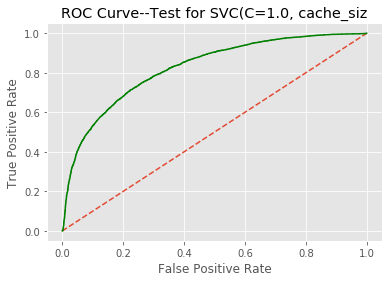

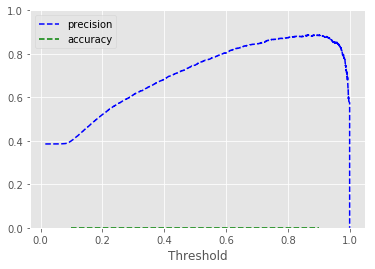

In [16]:
Machine_learning_testing_train_test_split(SVC(probability=True),X_transformed,y)

The score(Train)  for MultinomialNB(alpha= is: 0.9073383084577115
The score(Test)  for MultinomialNB(alpha= is: 0.7901515151515152
OverAll Confusion Matrix for MultinomialNB(alpha=
[[13213  1534]
 [ 1618  7635]]


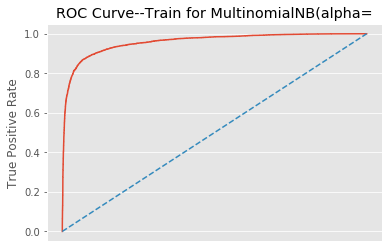

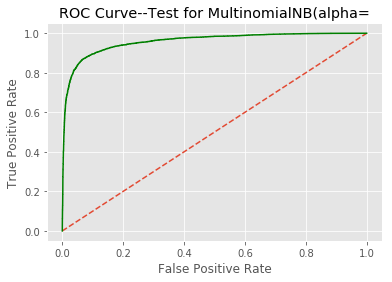

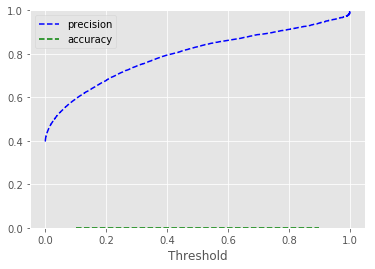

In [19]:
Machine_learning_testing_train_test_split(MultinomialNB(),X_transformed,y)

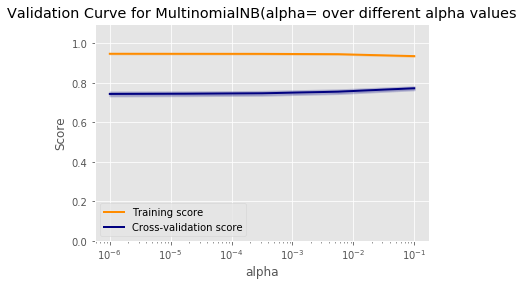

In [24]:
Cross_validation_curve_parameter(X_transformed,y,MultinomialNB())

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


The training score for MultinomialNB(alpha= with cv 5 [0.90197406 0.89989062 0.898125   0.90047393 0.90208843]
The testing score for MultinomialNB(alpha= with cv 5 [0.78483649 0.7908769  0.79291667 0.79724943 0.78412169]


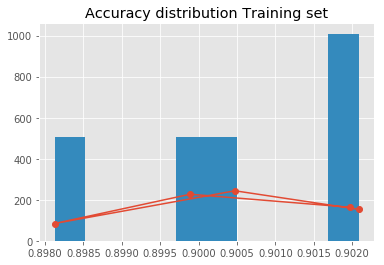

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


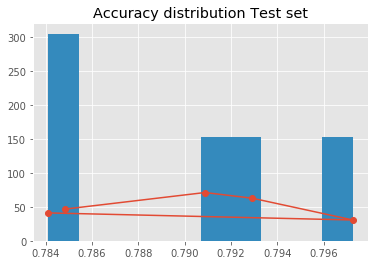

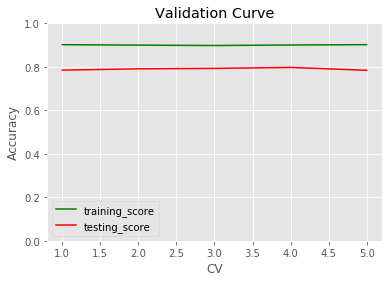

In [18]:
Cross_validation(X_transformed,y,MultinomialNB())

In [54]:
from tensorflow import keras
clf = keras.Sequential([
    keras.layers.Dense(128, input_shape=(X_transformed.shape[1],), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, input_shape=(X_transformed.shape[0],X_transformed.shape[1]), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, input_shape=(X_transformed.shape[0],X_transformed.shape[1]), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation="softmax")
])
clf.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               4204032   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                

In [59]:
clf.compile(loss="sparse_categorical_crossentropy",
optimizer="adam")
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y,test_size=0.33,random_state=42)
history = clf.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid))
clf.save("my_keras_model_cv.h5")

Train on 16080 samples, validate on 7920 samples
Epoch 1/10
16080/16080 [==============================] - 43s 3ms/sample - loss: 0.4980 - val_loss: 0.4539
Epoch 2/10
16080/16080 [==============================] - 38s 2ms/sample - loss: 0.3534 - val_loss: 0.4405
Epoch 3/10
16080/16080 [==============================] - 38s 2ms/sample - loss: 0.2870 - val_loss: 0.5659
Epoch 4/10
16080/16080 [==============================] - 38s 2ms/sample - loss: 0.2242 - val_loss: 0.4866
Epoch 5/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.1852 - val_loss: 0.4950
Epoch 6/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.1614 - val_loss: 0.4734
Epoch 7/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.1277 - val_loss: 0.6230
Epoch 8/10
16080/16080 [==============================] - 42s 3ms/sample - loss: 0.1262 - val_loss: 0.8864
Epoch 9/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.1289 - val_l

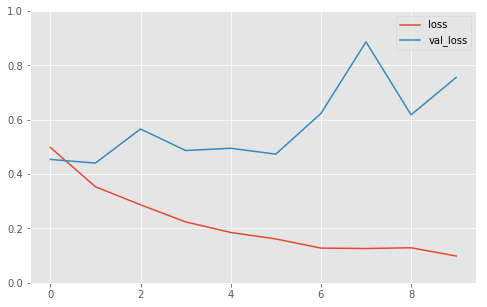

In [60]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

TDIDF

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score(Train)  for LogisticRegression(C is: 0.8607587064676617
The score(Test)  for LogisticRegression(C is: 0.8118686868686869
OverAll Confusion Matrix for LogisticRegression(C
[[13701  1046]
 [ 2683  6570]]


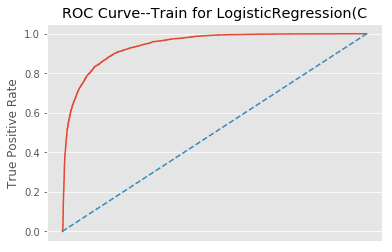

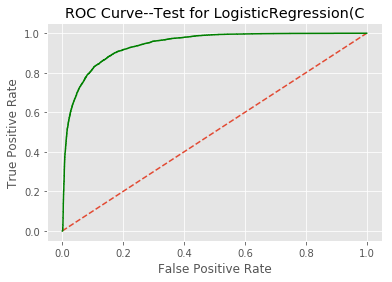

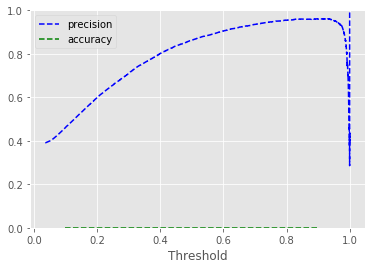

In [18]:
Machine_learning_testing_train_test_split(LogisticRegression(),X_transformed,y)

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


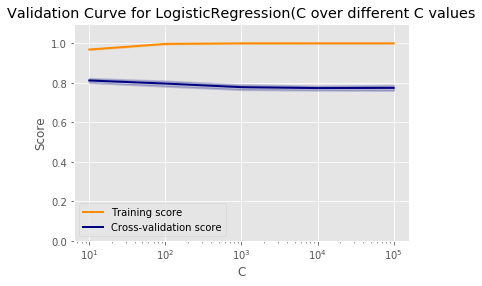

In [21]:
Cross_validation_curve_parameter(X_transformed,y,LogisticRegression())

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


The training score for LogisticRegression(C with cv 5 [0.86280535 0.86426376 0.86135417 0.8610489  0.86667361]
The testing score for LogisticRegression(C with cv 5 [0.81316392 0.82087065 0.81395833 0.81204418 0.79287352]


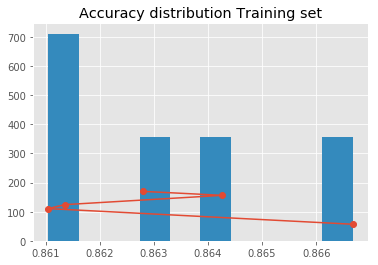

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


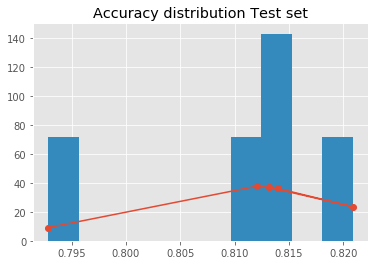

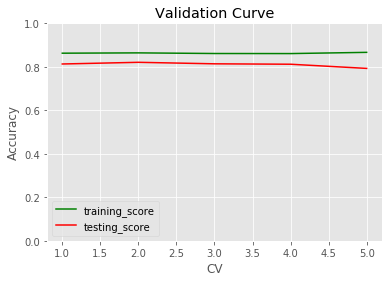

In [22]:
Cross_validation(X_transformed,y,LogisticRegression())

C:\Users\MMOHTASHIM\Anaconda3\envs\env_full\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


The score(Train)  for SVC(C=1.0, cache_siz is: 0.7543532338308457
The score(Test)  for SVC(C=1.0, cache_siz is: 0.7532828282828283
OverAll Confusion Matrix for SVC(C=1.0, cache_siz
[[13234  1513]
 [ 4391  4862]]


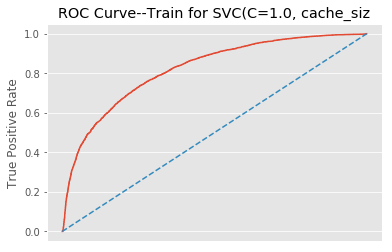

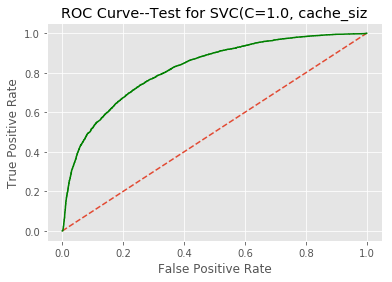

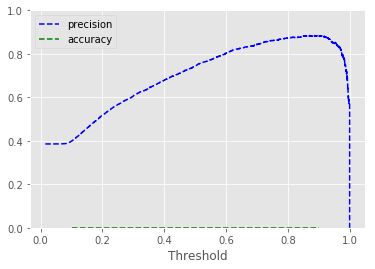

In [23]:
Machine_learning_testing_train_test_split(SVC(probability=True),X_transformed,y)

The score(Train)  for MultinomialNB(alpha= is: 0.8768656716417911
The score(Test)  for MultinomialNB(alpha= is: 0.7973484848484849
OverAll Confusion Matrix for MultinomialNB(alpha=
[[13725  1022]
 [ 2563  6690]]


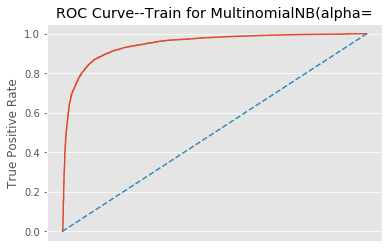

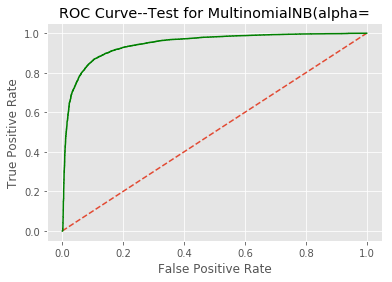

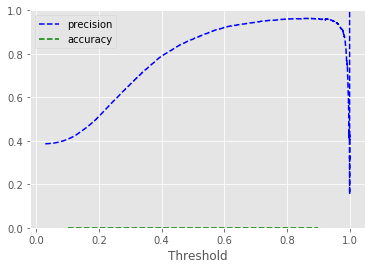

In [24]:
Machine_learning_testing_train_test_split(MultinomialNB(),X_transformed,y)

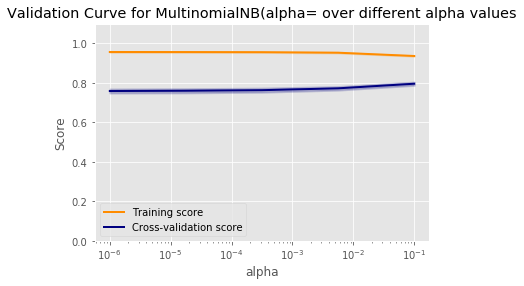

In [26]:
Cross_validation_curve_parameter(X_transformed,y,MultinomialNB())

In [62]:
from tensorflow import keras
clf = keras.Sequential([
    keras.layers.Dense(128, input_shape=(X_transformed.shape[1],), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, input_shape=(X_transformed.shape[0],X_transformed.shape[1]), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, input_shape=(X_transformed.shape[0],X_transformed.shape[1]), activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation="softmax")
])
clf.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               4204032   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                

In [63]:
clf.compile(loss="sparse_categorical_crossentropy",
optimizer="adam")
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y,test_size=0.33,random_state=42)
history = clf.fit(X_train, y_train, epochs=10,validation_data=(X_valid, y_valid))
clf.save("my_keras_model.h5")

Train on 16080 samples, validate on 7920 samples
Epoch 1/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.5342 - val_loss: 0.4792
Epoch 2/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.4296 - val_loss: 0.4186
Epoch 3/10
16080/16080 [==============================] - 38s 2ms/sample - loss: 0.3406 - val_loss: 0.4200
Epoch 4/10
16080/16080 [==============================] - 38s 2ms/sample - loss: 0.2890 - val_loss: 0.4672
Epoch 5/10
16080/16080 [==============================] - 38s 2ms/sample - loss: 0.2913 - val_loss: 0.4584
Epoch 6/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.2288 - val_loss: 0.4380
Epoch 7/10
16080/16080 [==============================] - 39s 2ms/sample - loss: 0.2095 - val_loss: 0.4707
Epoch 8/10
16080/16080 [==============================] - 38s 2ms/sample - loss: 0.2073 - val_loss: 0.5715
Epoch 9/10
16080/16080 [==============================] - 40s 2ms/sample - loss: 0.1921 - val_l

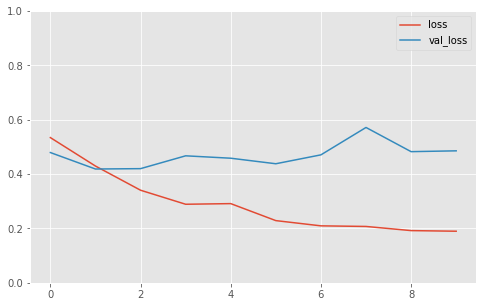

In [64]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

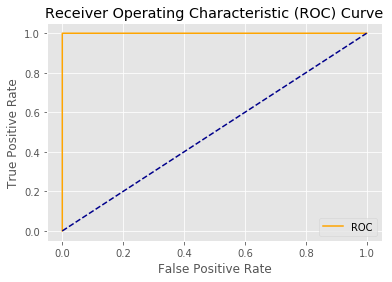

OverAll Confusion Matrix for Neural Network
[[12956  1791]
 [  698  8555]]


In [50]:
y_pred=clf.predict_classes(X_transformed)
probs=clf.predict_proba(X_transformed)[:,1]
##Now drawing roc curve for Neural Network
fpr, tpr, thresholds = roc_curve(y_pred, probs)
fig9=plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
##confusion matrix for neural network
print("OverAll Confusion Matrix for Neural Network")
print(confusion_matrix(y, y_pred))

In [53]:
test=pd.read_csv("haha_2019_test.csv")
test.set_index("id",inplace=True)
test.fillna(0,inplace=True)
X_test=train["text"]

In [89]:
X_vect=cv.transform(X_test)
sum_digits=[]
sum_char=[]
    
for j in X_test.str.findall(r"\W"):
    char_count=0
    for i in j:
        char_count+=1
    sum_char.append(char_count)
for j in X_test:
    spam_digit_count=0
    for i in j:
        if i.isdigit():
            spam_digit_count+=1
    sum_digits.append(spam_digit_count)
    
X_transformed_test=add_feature(X_vect,[[len(i) for i in X_test],sum_digits,sum_char])

In [91]:
y_pred=clf.predict_classes(X_transformed_test)

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)